In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
import pandas as pd
import lime
import lime.lime_tabular
import numpy as np

In [2]:
# Load the dataset
data = pd.read_csv('/Users/grace/Desktop/Courses/Master_thesis/dataset1.csv')

In [3]:
# Separate the target variable
target_variable = 'time_on_site [Minutes]'
X = data.drop(target_variable, axis=1)
y = data[target_variable]

In [4]:
# Initialize the Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Initialize the LOOCV iterator
loo = LeaveOneOut()

# Initialize a list to store the mean squared error scores
mse_scores = []

# Loop through each training/testing split
for train_index, test_index in loo.split(X):
    # Split the data into training and testing sets for this iteration
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Fit the regressor on the training data
    rf.fit(X_train, y_train)
    # Make predictions on the test data
    y_pred = rf.predict(X_test)
    
    # Calculate the mean squared error score for this iteration
    mse = mean_squared_error(y_test, y_pred)
    
    # Add the mean squared error score to the list
    mse_scores.append(mse)

In [5]:
# Calculate the mean mean squared error score across all iterations
mean_mse = sum(mse_scores) / len(mse_scores)
print("Mean mean squared error score: {:.2f}".format(mean_mse))

Mean mean squared error score: 509.71


In [6]:
# Get the feature importances
importances = rf.feature_importances_

# Create a DataFrame of feature importances sorted from highest to lowest
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False)

# Print the top 10 features with their importances
print(feature_importances.head(10))

            feature  importance
2       value [USD]    0.487990
0       customer_id    0.277989
3    clicks_in_site    0.137192
1  product_category    0.096829


In [7]:
# Select the top k features
k = 10
top_k_features = feature_importances['feature'][:k].tolist()

# Select the features from the dataset
X_train_selected = X_train[top_k_features]
X_test_selected = X_test[top_k_features]

In [8]:
# Train the Random Forest regressor on the selected features
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train_selected, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [9]:
# Define a function to generate explanations using LIME
def explain_instance(x, model):
    explainer = lime.lime_tabular.LimeTabularExplainer(training_data=np.array(X_train_selected),
                                                       feature_names=top_k_features, 
                                                       class_names=[target_variable], 
                                                       verbose=True, mode='regression')
    exp = explainer.explain_instance(x, model.predict, num_features=k)
    return exp.as_list()

In [10]:
# Define the hyperparameter grid to search
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [11]:
# Pick a random test instance to generate an explanation for
test_instance = X_test.iloc[0]
print("Selected test instance: ")
print(test_instance)
print("True target value: ", y_test.iloc[0])

Selected test instance: 
customer_id         25626.00
product_category      513.00
value [USD]           248.72
clicks_in_site         17.00
Name: 198, dtype: float64
True target value:  11.3


In [12]:
# Generate an explanation for the test instance using LIME
exp = explain_instance(test_instance, rf)
print("LIME explanation for the selected instance: ")
print(exp)

Intercept 24.025358815129042
Prediction_local [48.82518708]
Right: 56.81112777777775
LIME explanation for the selected instance: 
[('clicks_in_site > 16.00', 13.469301933481619), ('value [USD] > 234.28', 12.030888611024128), ('product_category <= 504.00', -2.511781911155953), ('customer_id <= 26075.25', 1.8114196361659831)]


C:\Users\grace\anaconda3\envs\XAI\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: Axis limits cannot be NaN or Inf

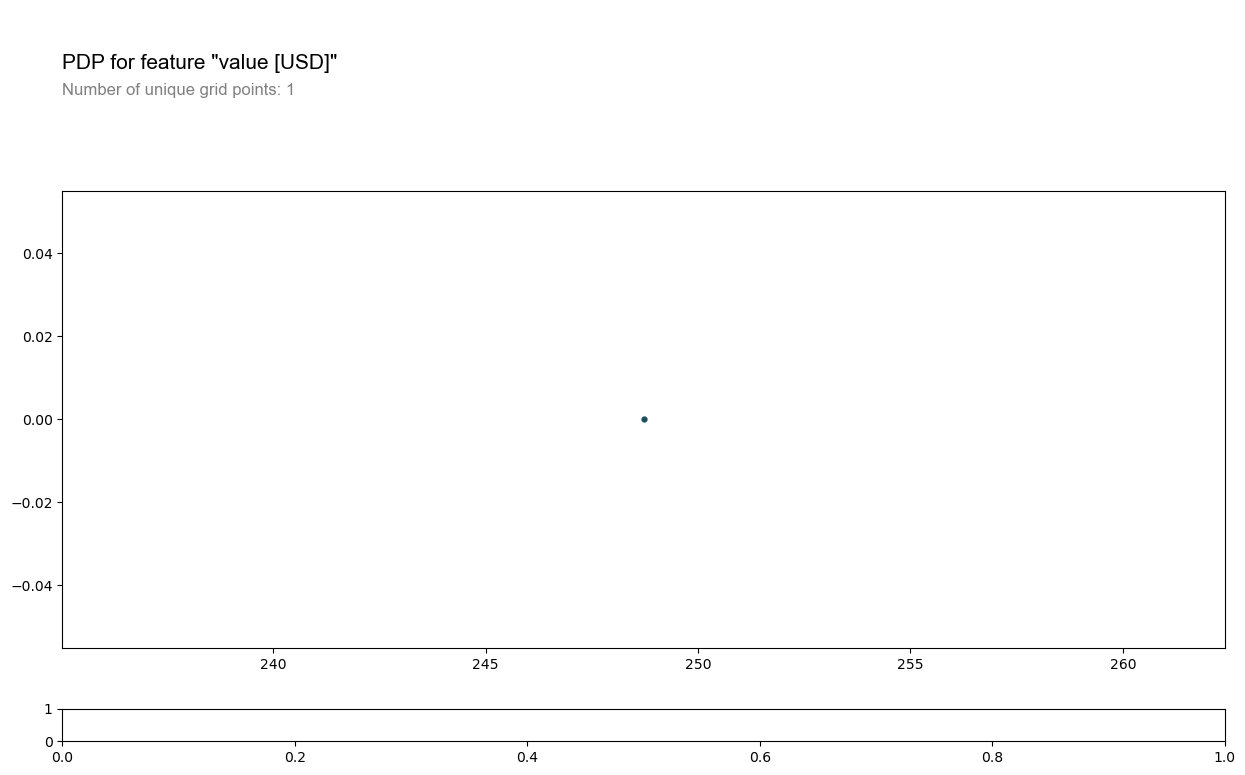

In [14]:
from pdpbox import pdp, get_dataset, info_plots
import matplotlib.pyplot as plt

# Define the feature to plot
feature_name = top_k_features[0]

# Create the data for the PDP plot
pdp_data = pdp.pdp_isolate(model=rf, dataset=X_test_selected, model_features=top_k_features, feature=feature_name)

# Plot the PDP
fig, axes = pdp.pdp_plot(pdp_data, feature_name, plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

# Add a title to the plot
axes['pdp_ax'].set_title(f"PDP for {feature_name}")

plt.show()
